# DepthAI Tutorial: Training a Tiny YOLOv4 Object Detector with Your Own Data

<!-- <img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">
 -->

<img src="https://drive.google.com/uc?id=1nRyGDFel__MT2zpu_5hC1P2cHMTKJvzX" width="500">



Welcome to DepthAI! 

In this tutorial we will train an object detector using the Tiny YOLOv4 model. This model will run on our DepthAI Myriad X modules.

The model is pretrained on the COCO dataset. The framework used for training is Darknet.
Will run through the following steps:


*   Install the libraries (Darknet , etc.)
*   Clone the github repo containing images and parameter files
*   Set up model parameters and train model with medical mask images from repo
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file 

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: you can train on your own images if you replace the images in the cloned repo with your own

## STEP 1 Install Darknet


In [1]:
%%capture
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [4]:
#utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  


## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint. 
Changes to some files need to be made according to own data, but it is nothing complicated.

In [5]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Total 1733 (delta 0), reused 0 (delta 0), pack-reused 1733
Receiving objects: 100% (1733/1733), 208.88 MiB | 31.70 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Checking out files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


### Now go to the file explorer on the left of the colab notebook and click on content then on the yolotinyv3_medmask_demo folder.
Here you will see a folder and a few files.
The `obj` folder contains both images AND the associated annotations in yolo format. 

(to annotate own images use https://github.com/tzutalin/labelImg and save annotations in yolo format)

* the 'obj.data' file contains paths for files used by Darknet and the number of classes to train the yolo model.

* the 'obj.names' file has the labels of the objects to be detected. the number of objects gives the number of classes in the 'obj.data' file.

* the train.txt contains the path to each image to be used in training. similarly, valid.txt and test.txt contain the path to each image for validation and testing. when not many images are available for training (a few hundred), use all images for training for better model performance.

* the yolov4-tiny.conv.29 are the COCO pretrained weights 

* the yolov4-tiny_obj.cfg are is the tiny yolov4 configuration file that tells Darknet the model parameters and structure

So we can see that all these files need to be changed according to own data.


Then copy from your cloned repo folder with images and annotations to the `obj` folder

## Change the labels in obj.names to our current labels

In [6]:
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['mask','no mask']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

mask
no mask

## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [7]:
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes= 2
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/valid.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

## Now we need to create a train.txt, valid.txt and test.txt file for our images from `obj` folder.
We will use a script that splits the images based on a specified percentage 
and writes them in train.txt, valid.txt and test.txt files.

In [8]:
%cd ../yolotinyv3_medmask_demo/

/content/yolotinyv3_medmask_demo


In [9]:
#in this case we use 85 percent of the images for training
#10 percent for validation, 5 for testing.
#as the dataset is small, one can use 90 percent for training and split the rest
#for validation/testing as desired.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
!python3 folder2textYolo.py 85 10 /content/yolotinyv3_medmask_demo/obj

Your image file extension is: .jpg
Number of images: 762
Number of images used for training 648
Number of images used for validation 76
Number of images used for testing 38


## Last thing we need to change is the yolov4-tiny_obj.cfg file.
There are several parameters of importance here. They control various aspects of the training process. Let's print the first few lines and have a look


In [10]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=1
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1



### Let's go over the parameters above:
* The batch parameter dictates the batch size. That one generally remains at 64.
* The subdivisions dictates how many images are loaded into memory. A smaller number translates to faster training. We will use 12. If a CUDA out of memory error is triggered, the subdivisions should be increased to i.e. 16,24,32 or some other number. (64 is max) Unless training with a resolution higher than 416, there should be no problem with 12.
* The width and height are by default at 416. Another resolution one can try is 320, or 608.
* The next parameter we care about is max_batches. This determines how long the training process is. Its value should be at least around 2000 for every class used. So for 3 classes, at least 6000.
* The steps are calculated as a function of max_batches. The first value is 0.8 * max_batches and the second value 0.9 * max_batches. In this case it is 8000 * 0.8 and 8000 * 0.9. 

For more details about Yolo parameters have a look here:
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects
There is a lot of material here, so make sure you scroll through if you have questions. Pretty much everything is well explained.




### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [11]:
# set the number of max_batches - min 2000 per class:
max_batch=8000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch
#subdivisions define the minibatch size: minibatch = batch/subdivisions
#we set subdivisions to 4. if using larger resolutions, may have to increase
#the this number to 8 16 or even 32. default resolution is 416x416
subdivisions = 4


# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3

cfg_file = '/content/yolotinyv3_medmask_demo/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('subdivisions=\d*','subdivisions='+str(subdivisions),s)
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



Let's look again at the configuration 

In [ ]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg



[net]
# Testing
#batch=1
#subdivisions=4
# Training
batch=64
subdivisions=4
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 8000
policy=steps
steps=6400,7200
scales=.1,.1



We also check if the number of classes and filters updated correctly

In [ ]:
!tail -n 64 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg 


mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6


# Train the model

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

In the `content/darknet/backup/` folder Darknet saves a few weights files:
* files that end in 1000,2000 etc are weights saved every 1000 batches
* best weights file are the weights that gave best results during training
* final weights file contains the final weights at the end of the training





## Start the model training
For training details check here: 

https://github.com/AlexeyAB/darknet#how-to-train-tiny-yolo-to-detect-your-custom-objects

In [12]:
%cd ../darknet/

/content/darknet


In [13]:
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg /content/yolotinyv3_medmask_demo/yolov4-tiny.conv.29 -dont_show -ext_output -map

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 

## Check the model performance
The metrics run on the validation images so they may not be fully representative, only indicative

In [14]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg "/content/darknet/backup/yolov4-tiny_best.weights" -points 0

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

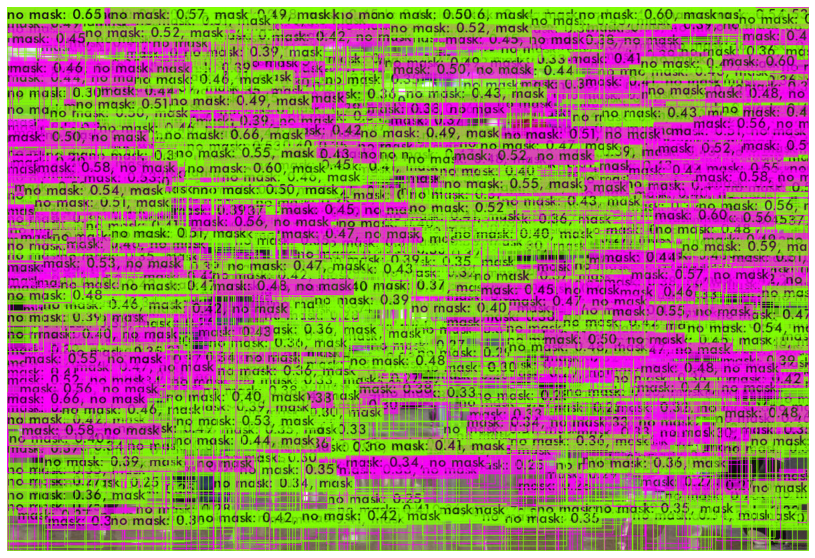

In [15]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" /content/yolotinyv3_medmask_demo/obj/0633.jpg -ext_output
imShow('predictions.jpg')

## Copy best weights to google drive (Optional)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/darknet/backup/yolov4-tiny_best.weights  '/content/drive/My Drive/'

# Convert model so it can be used on DepthAI
This requires three steps:
1. Convert model to Tensorflow frozen model
2. Convert Tf model to OpenVINO IR files .xml and .bin
3. Compile a blob from the IR files. The blob can be used for inference on DepthAI modules.

### Convert YOLO model to Tensorflow frozen model


In [16]:
%cd /content

/content


In [17]:
#clone a repo that helps with the conversion
!git clone https://github.com/TNTWEN/OpenVINO-YOLOV4.git
%cd OpenVINO-YOLOV4/

Cloning into 'OpenVINO-YOLOV4'...
remote: Enumerating objects: 667, done.
remote: Counting objects: 100% (462/462), done.
remote: Compressing objects: 100% (419/419), done.
remote: Total 667 (delta 108), reused 337 (delta 29), pack-reused 205
Receiving objects: 100% (667/667), 48.14 MiB | 30.17 MiB/s, done.
Resolving deltas: 100% (219/219), done.
/content/OpenVINO-YOLOV4


Convert the best yolo weights to Tensorflow frozen model. 
The name and location of the frozen model is


 `/content/tensorflow-yolo-v3/frozen_darknet_yolov4_model.pb`

In [18]:
!python3 convert_weights_pb.py --class_names /content/yolotinyv3_medmask_demo/obj.names --data_format NHWC --weights_file /content/darknet/backup/yolov4-tiny_best.weights --tiny


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0602 10:58:24.849881 139976292968320 module_wrapper.py:139] From convert_weights_pb.py:38: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0602 10:58:24.858148 139976292968320 module_wrapper.py:139] From convert_weights_pb.py:40: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

Instructions for updating:
Please use `layer.__call__` method instead.
W0602 10:58:24.865101 139976292968320 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/contrib/layers/python/layers/layers.py:1057: Layer.apply (from tensorflow.python.keras.engine.

###Install OpenVINO 2021.3

In [19]:
%cd /content

/content


In [20]:
import os
from urllib.parse import urlparse

## install tools. Open Vino takes some time to download - it's ~400MB
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove

## downnload installation files
url = "https://registrationcenter-download.intel.com/akdlm/irc_nas/17662/l_openvino_toolkit_p_2021.3.394.tgz"
!wget {url}

## Get the name of the tgz
parsed = urlparse(url)
openvino_tgz = os.path.basename(parsed.path)
openvino_folder = os.path.splitext(openvino_tgz)[0]

## Extract & install openvino
!tar xf {openvino_tgz}
%cd {openvino_folder}
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libpci3
Suggested packages:
  libarchive1
The following NEW packages will be installed:
  cpio libpci3 pciutils
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 368 kB of archives.
After this operation, 1,786 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 cpio amd64 2.12+dfsg-6ubuntu0.18.04.1 [86.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpci3 amd64 1:3.5.2-1ubuntu1.1 [24.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 pciutils amd64 1:3.5.2-1ubuntu1.1 [257 kB]
Fetched 368 kB in 1s (326 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dia

###Convert frozen TF model to OpenVINO 21.03 IRv10
--input model is the path to the frozen model from above

--output_dir is where we want to save the converted IR files: .xml .bin and .mapping. we save it in TinyIR in the /content/yolotinyv3_medmask_demo directory

In [21]:
%cd /content

/content


In [22]:
import re
tiny_yolo_json = '/content/OpenVINO-YOLOV4/yolo_v4_tiny.json'
with open(tiny_yolo_json) as f:
    s = f.read()
s = re.sub('"classes": \d*','"classes": ' + str(len(labels)),s)
with open(tiny_yolo_json, 'w') as f:
  f.write(s)
#Check that the number of classes is correct (same as the number of your training labels)|
!cat /content/OpenVINO-YOLOV4/yolo_v4_tiny.json 

[
  {
    "id": "TFYOLOV3",
    "match_kind": "general",
    "custom_attributes": {
      "classes": 2,
      "anchors": [10, 14, 23, 27, 37, 58, 81, 82, 135, 169, 344, 319],
      "coords": 4,
      "num": 6,
      "masks": [[3, 4, 5], [1, 2, 3]],
      "entry_points": ["detector/yolo-v4-tiny/Reshape", "detector/yolo-v4-tiny/Reshape_4"]
    }
  }
]


In [23]:
# Get openvino installation path
openvino = !find /opt/intel -type d -name openvino*
!python -mpip install -r {openvino[0]}/deployment_tools/model_optimizer/requirements.txt

!source {openvino[0]}/bin/setupvars.sh && \
    python {openvino[0]}/deployment_tools/model_optimizer/mo.py \
--input_model /content/OpenVINO-YOLOV4/frozen_darknet_yolov4_model.pb \
--tensorflow_use_custom_operations_config /content/OpenVINO-YOLOV4/yolo_v4_tiny.json  \
--batch 1 \
--data_type FP16 \
--reverse_input_channel \
--output_dir /content/yolotinyv3_medmask_demo/TinyIR

Ignoring tensorflow: markers 'python_version >= "3.8"' don't match your environment
     |████████████████████████████████| 68.7MB 87kB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 12.2MB 50.1MB/s 
     |████████████████████████████████| 143kB 59.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=4a27c794c8ddc9d6be47ebf4a396563dfabc9b0b1752b97b5c1d7265dcbc11a7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: lucid 0.3.10 requires umap-learn, which is not installed.
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatib

## Now we compile the IR model to a .blob for use on DepthAI modules/platform

### We save the blob in the IR directory from above, corresponding to --output_dir parameter above. 
The blob filename and location will be

 `/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.blob`

In [24]:
# Choose the directory where you would like to save the blob.
blob_dir = "/content/yolotinyv3_medmask_demo/TinyIR/"

binfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.bin"
xmlfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.xml"

!python -m pip install blobconverter

import blobconverter
blob_path = blobconverter.from_openvino(
    xml=xmlfile,
    bin=binfile,
    data_type="FP16",
    shaves=5,
)
from google.colab import files
files.download(blob_path)

     |████████████████████████████████| 133kB 8.3MB/s 
     |████████████████████████████████| 7.6MB 10.5MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
     |████████████████████████████████| 133kB 59.3MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.5
    Uninstalling urllib3-1.26.5:
      Successfully uninstalled urllib3-1.26.5
[==================================================]
Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Name the archive as you see fit
!tar czvf medmask_tinyv3.tar.gz /content/yolotinyv3_medmask_demo/TinyIR
# Save the archive to the gdrive
from google.colab import files
files.download("fine_tuned_model.tar.gz")

tar: Removing leading `/' from member names
/content/yolotinyv3_medmask_demo/TinyIR/
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.bin
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.mapping
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.xml
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.blob


# Run the blob on DepthAI

To use this blob with DepthAI:

- Clone depthai demo script

    ```
    $ git clone https://github.com/luxonis/depthai.git
    ```
- Install requirements

    ```
    $ python3 install_requirements.py
    ```
- Create a new model directory and insert the blob

    ```
    $ mkdir resources/nn/custom_medmask
    $ mv <downloaded_blob> resources/nn/custom_medmask/
    ```

- Copy config file from mobilenet-ssd model

    ```
    $ cp resources/nn/tiny-yolo-v3/tiny-yolo-v3.json resources/nn/custom_medmask/custom_medmask.json
    ```

- Run the demo script

    ```
    $ python3 depthai_demo.py -cnn custom_medmask
    ```

You can read more details on deployment [here](https://docs.luxonis.com/en/latest/pages/tutorials/first_steps/#using-custom-models)

